In [1]:
from pickle import dump 
import re
import numpy as np
from unicodedata import normalize
import string

<h3>Read data</h3>
<p>Data from http://www.manythings.org/, German words and their translations</p>

In [17]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [18]:
doc = load_doc('data/deu-eng/deu.txt')

In [19]:
doc[:20]

'Hi.\tHallo!\nHi.\tGrüß '

<h3>Cleaning the data</h3>

In [20]:
def to_pairs(doc):
    lines = doc.split('\n')
    pairs = [x.split('\t') for x in lines]
    return pairs

In [21]:
pairs = to_pairs(doc)
pairs[:5]

[['Hi.', 'Hallo!'],
 ['Hi.', 'Grüß Gott!'],
 ['Run!', 'Lauf!'],
 ['Fire!', 'Feuer!'],
 ['Help!', 'Hilfe!']]


- Remove all non-printable characters.
- Remove all punctuation characters.
- Normalize all Unicode characters to ASCII (e.g. Latin characters).
- Normalize the case to lowercase.
- Remove any remaining tokens that are not alphabetic.


In [26]:
# clean a list of lines
def clean_pairs(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return np.array(cleaned)

The unicodedata module offers a .normalize() function, you want to normalize to the NFC form. NFC, or 'Normal Form Composed' returns composed characters, NFD, 'Normal Form Decomposed' gives you decomposed, combined characters.

In [27]:
cleaned_pairs = clean_pairs(pairs)
cleaned_pairs[:5]

array([list(['hi', 'hallo']), list(['hi', 'gru gott']),
       list(['run', 'lauf']), list(['fire', 'feuer']),
       list(['help', 'hilfe'])], dtype=object)

<h3>Save the cleansed data</h3>

In [32]:
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [38]:
save_clean_data(cleaned_pairs, "data/deu-eng/cleansed_deu.pkl")

Saved: data/deu-eng/cleansed_deu.pkl


<h3>Loading the processed data</h3>

In [2]:
from pickle import load
from numpy.random import rand
from numpy.random import shuffle

In [3]:
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

In [4]:
raw_dataset = load_clean_sentences('data/deu-eng/cleansed_deu.pkl')

In [5]:
raw_dataset[:5]

array([list(['hi', 'hallo']), list(['hi', 'gru gott']),
       list(['run', 'lauf']), list(['fire', 'feuer']),
       list(['help', 'hilfe'])], dtype=object)

In [6]:
len(raw_dataset)

169814

<h3>Tokenize</h3>

In [7]:
N = 20000

In [8]:
import pandas as pd

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [9]:
raw_dataset = pd.DataFrame([x for x in raw_dataset[:N]], columns = ['English', 'German'])

In [10]:
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [11]:
en_length = max_length(raw_dataset["English"].tolist())
de_length = max_length(raw_dataset["German"].tolist())
en_length, de_length

(6, 10)

In [12]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [13]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [14]:
en_tokenizer = create_tokenizer(raw_dataset["English"].tolist())
de_tokenizer = create_tokenizer(raw_dataset["German"].tolist())
en_vocab_size = len(en_tokenizer.word_index) + 1
de_vocab_size = len(de_tokenizer.word_index) + 1
en_vocab_size, de_vocab_size

(3753, 5814)

<h3>Viewing output of tokenizer</h3>

In [30]:
en_token_mapping = pd.DataFrame.from_dict(en_tokenizer.word_index, orient = 'index')
en_token_mapping[:5]

,0
tom,1
i,2
is,3
you,4
it,5


This is how the keras preprocessing tokenizes the english text, now we do the same for german texts.

<h3>Test Train split</h3>

In [18]:
from sklearn.utils import shuffle

In [19]:
def floor(n):
    res = int(n)
    return res if res == n or n >= 0 else res-1

In [20]:
def index_marks(nrows, chunk_size):
    return range(1 * chunk_size, (nrows // chunk_size + 1) * chunk_size, chunk_size)

indices = list(index_marks(len(raw_dataset), 6000))
print("Marks: {}".format(indices))

Marks: [6000, 12000, 18000]


In [28]:
def test_train_split(data, test_frac, indices):
    n = len(data)
    #shuffle the dataset
    data = shuffle(data)
    #calc row no from test_frac
    test_no = floor(n * test_frac)
    test = data[:test_no]
    print("len of testing data :", len(test))
    
    #for training data
    data = shuffle(data[test_no:])
    print("len of training data :", len(data))
    train = np.array_split(data, indices)
    return test, train, data

In [29]:
test, train, complete_train = test_train_split(raw_dataset, 0.1, indices)

len of testing data : 2000
len of training data : 18000


In [23]:
train[0][:5], len(train[0])

(                 English                     German
 6705      the birds sang           die vogel sangen
 9732      these are toms            die gehoren tom
 11467   do you play golf            spielt ihr golf
 10992     you arent here        ihr seid nicht hier
 15234  are you the mayor  bist du der burgermeister, 6000)

In [24]:
test[:5], len(test)

(                English                      German
 14471  tom was unafraid       tom hatte keine angst
 582            im dying      ich werde bald sterben
 11869  here is your bag        hier ist ihre tasche
 3827      i am to blame         es ist meine schuld
 4358      just check it  kontrollieren sies einfach, 2000)

<h3>Save the train test data</h3>

In [25]:
len(train)

4

In [26]:
test.to_pickle("test.h5")
i = 1
for chunks in train:
    chunks.to_pickle("train_" + str(i) +".h5")
    i += 1

In [30]:
complete_train.to_pickle("complete_train.h5")

In [64]:
complete_train.to_csv( "complete_train.txt", sep='|', index=False, header=False)

<h3>Creating a class for data generation</h3>

ID be the Python string that identifies a given sample of the dataset

<h3>Load train test data</h3>

In [16]:
test = pd.read_pickle("test.h5")
complete_train = pd.read_pickle("complete_train.h5")

We have tokenized the entire dataset, now we need to apply this to the training and testing dataset using the tokenizer created. We need to encode each sequence to max length to be used as a word embedding. Keras pad sequence helps to pad all sequences into similar length. 'post' padding option allows us to add 0's after each sequence to complete the max length.

In [17]:
from keras.preprocessing.sequence import pad_sequences 

In [18]:
def encode_seq(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_matrix(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

The final layer would be a probablity distribution of each word appearing in the sentence and hence has to be one hot encoded layer.

In [20]:
from keras.utils import to_categorical
#Converts a class vector (integers) to binary class matrix.

In [31]:
def encode_output(sequence, vocab_size):
    ylist = list()
    encoded = to_categorical(sequence, num_classes=vocab_size)
    ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequence.shape[0], sequence.shape[1], vocab_size)
    return y

In [32]:
import pickle

In [33]:
# def generate_arrays_from_file(path):
#     while True:
#             with open(path) as f:
#                 for line in f:
#                     x, y = line.split("|")
#                     y = y.strip("\n")
#                     print(x," | ",  y)
#                     break
#                 break

In [34]:
#Define a data generator to call data in batches

def generate_arrays_from_file(path, en_tokenizer, en_length, de_vocab_size):
    with open(path) as f:
        for line in f:
            # create numpy arrays of input data
            # and labels, from each line in the file
            trainX, trainY = line.split("|")
            trainY = trainY.strip("\n")

            print(trainX)

            trainX = encode_seq(en_tokenizer, en_length, trainX)
            trainY = encode_seq(de_tokenizer, de_length, trainY)
            print(trainX.shape)

            trainY = encode_output(trainY, de_vocab_size)

            return ({'input_1': trainX}, {'output': trainY})


In [35]:
generate_arrays_from_file("complete_train.txt", en_tokenizer, en_length, de_vocab_size)

im useless
(10, 6)


({'input_1': array([[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]], dtype=int32)},
 {'output': array([[[1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          ...,
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.]],
  
         [[1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          ...,
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.]],
  
         [[1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          [1., 0., 0., ..., 0., 0., 0.],
          ...,
     

In [31]:
# trainY = encode_output(trainY[:5000], de_vocab_size)

In [32]:
# trainY[:5].shape

(5, 10, 3686)

In [33]:
# trainY[:1]

array([[[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]])

In [39]:
testX = encode_seq(en_tokenizer, en_length, test["English"].tolist())
testY = encode_seq(de_tokenizer, de_length, test["German"].tolist())
testY = encode_output(testY, de_vocab_size)

<h3>Model</h3>

In [40]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

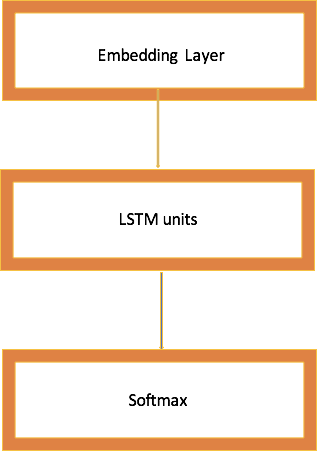

In [41]:
def def_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units)) #encoder
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

In [43]:
model = def_model(en_vocab_size, de_vocab_size, en_length, de_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy') #use adam to train the model

In [44]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 6, 256)            960768    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 256)           525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 5814)          1494198   
Total params: 3,505,590
Trainable params: 3,505,590
Non-trainable params: 0
_________________________________________________________________
None


We must connect the encoder to the decoder, and they do not fit.

That is, the encoder will produce a 2-dimensional matrix of outputs, where the length is defined by the number of memory cells in the layer. The decoder is an LSTM layer that expects a 3D input of [samples, time steps, features] in order to produce a decoded sequence of some different length defined by the problem.

If you try to force these pieces together, you get an error indicating that the output of the decoder is 2D and 3D input to the decoder is required.

We can solve this using a <b>RepeatVector layer</b>. This layer simply repeats the provided 2D input multiple times to create a 3D output.

<h3>Save the model</h3>

In [45]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

<h3>Train the model</h3>

In [81]:
model.fit_generator(generate_arrays_from_file('complete_train.txt', de_vocab_size), steps_per_epoch=6000, epochs=10, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Epoch 1/10


ValueError: No data provided for "embedding_1_input". Need data for each key in: ['embedding_1_input']

<h3>Loading the saved model</h3>

In [41]:
from keras.models import load_model

In [42]:
model = load_model('model.h5')

In [43]:
translation = model.predict(testX, verbose=0)

In [44]:
translation[0] #probablity distribution of first sequence

array([[7.2011976e-06, 8.1534272e-01, 1.6022379e-02, ..., 1.5784324e-09,
        2.6694651e-09, 2.1605746e-09],
       [2.4934425e-05, 5.0718516e-02, 9.4015925e-04, ..., 3.8430712e-09,
        6.1699046e-09, 4.5124149e-09],
       [3.8303973e-04, 3.1723335e-02, 8.1044942e-02, ..., 1.0078786e-08,
        1.7822506e-08, 1.1264025e-08],
       ...,
       [9.9778193e-01, 4.0095761e-06, 1.0868539e-05, ..., 9.6096056e-12,
        2.1693572e-11, 1.1184460e-11],
       [9.9870932e-01, 1.6168731e-06, 4.6534847e-06, ..., 5.0155565e-12,
        1.1453427e-11, 6.0343579e-12],
       [9.9913824e-01, 8.7311832e-07, 2.4852766e-06, ..., 3.3935276e-12,
        7.4892124e-12, 4.0524363e-12]], dtype=float32)

In [45]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

We can perform this mapping for each integer in the translation and return the result as a string of words.

In [46]:
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

This function will select the word with maximum probablity and then append to get the predicted sentence

In [47]:
predictions = predict_sequence(model, de_tokenizer, testX)

<h3>Evaluation</h3>

Evaluation for machine translation is mainle done using a score called BLEU https://www.aclweb.org/anthology/P02-1040.pdf. For this we need to import corpus_bleu from nltk.

In [49]:
from nltk.translate.bleu_score import corpus_bleu

In [50]:
def evaluate_model(model, tokenizer, sources, raw_dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_sequence(model, tokenizer, source)
        raw_target = [x[1] for x in dataset][i]
        raw_src = [x[0] for x in dataset][i]
        if i < 5:
            print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
        actual.append(raw_target.split())
        predicted.append(translation.split())
    # calculate BLEU score
#     print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
#     print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
#     print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
#     print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [51]:
evaluate_model(model, de_tokenizer, testX, test)

src=[tom got mugged], target=[tom wurde uberfallen], predicted=[ich habe es gut]
src=[you can rest], target=[sie konnen sich ausruhen], predicted=[du sind gut]
src=[did you do that], target=[habt ihr das getan], predicted=[tom ist]
src=[this is new], target=[das ist neu], predicted=[tom hat mich]
src=[tom is nervous], target=[tom ist nervos], predicted=[ich mag sehr]


In [52]:
print(testX[:5])

[[   2 1001   18  166    0]
 [  26  356    0    0    0]
 [   1  456  593    0    0]
 [   1 2248    8    0    0]
 [   2   33  494    0    0]]


In [53]:
print(test[:5])

[list(['i led the way', 'ich ging voran'])
 list(['youre worried', 'ihr macht euch sorgen'])
 list(['tom drank milk', 'tom trank milch'])
 list(['tom punched me', 'tom hat mich geschlagen'])
 list(['i like wine', 'ich mag wein'])]
